In [3]:
%matplotlib inline

import math
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Define a simple function
def f(x):
    return 3*x**2 - 4*x + 5

In [5]:
f(3.0)

20.0

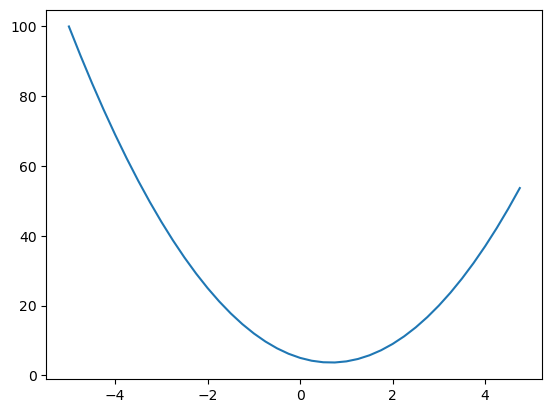

In [6]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

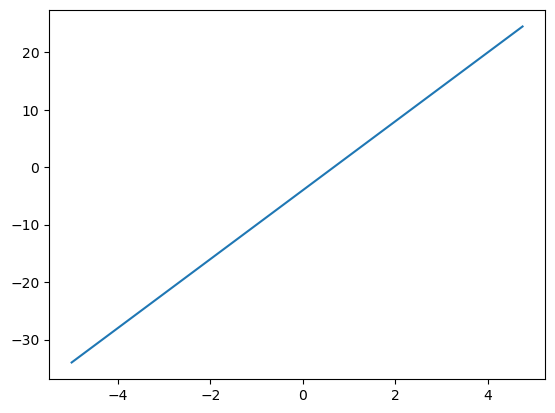

In [7]:
# Determine the derivative
h = 0.001
dys = (f(xs + h) - f(xs)) / h
plt.plot(xs, dys)

In [8]:
# Define a more complex function
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [9]:
h = 0.001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1a = (a + h)*b + c
d1b = a*(b + h) + c
d1c = a*b + (c + h)

print(f"dd/da: {(d1a - d) / h}")
print(f"dd/db: {(d1b - d) / h}")
print(f"dd/dc: {(d1c - d) / h}")

dd/da: -3.0000000000001137
dd/db: 1.9999999999997797
dd/dc: 0.9999999999994458


In [99]:
# Define Value class

class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), _op='+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), _op='*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += (other * self.data ** (other-1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [39]:
# Plot computation graph
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        # dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [ ]:
# Example graph
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd' 
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

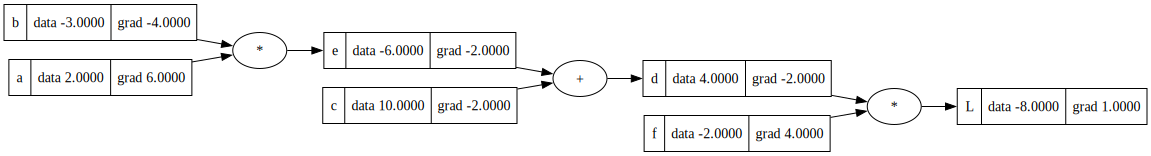

In [53]:
# Plot example graph
draw_dot(L)

In [ ]:
# Manually deriving gradients
# Reminder: chain rule
# L = d * f
# dL/dd = f
#
# Derivative: (f(x+h) - f(x)) / h)
# Here: ((d+h)*f - d*f) / h
#     = (d*f + h*f - d*f) / h
#     = (h*f) / h = f
#     q.e.d.

# Gradients
# dL/dL = 1
# 
# dL/dd = d(d*f)/dd = f = -2
# dL/df = d(d*f)/df = d = 4
# 
# dL/de = d(d*f)/de = d((e+c)*f)/de = d(e+c)/de * d(d*f)/dd = d(e+c)/de * dL/dd = 1 * f = -2
# dL/dc = d(d*f)/dc = d((e+c)*f)/dc = d(e+c)/dc * d(d*f)/dd = d(e+c)/dc * dL/df = 1 * d = 4
# # Shortened
# dL/de = dd/de * dL/dd = 1 * -2 = -2
# dL/dc = dd/dc = dL/dd = 1 * -2 = -2
# 
# dL/db = de/db * dL/de = a * -2 = -4
# dL/da = de/da * dL/de = b * -2 = 6

# Manual backpropagation
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
e.grad = -2.0
c.grad = -2.0
b.grad = -4.0
a.grad = 6.0

In [100]:
# Build a single neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

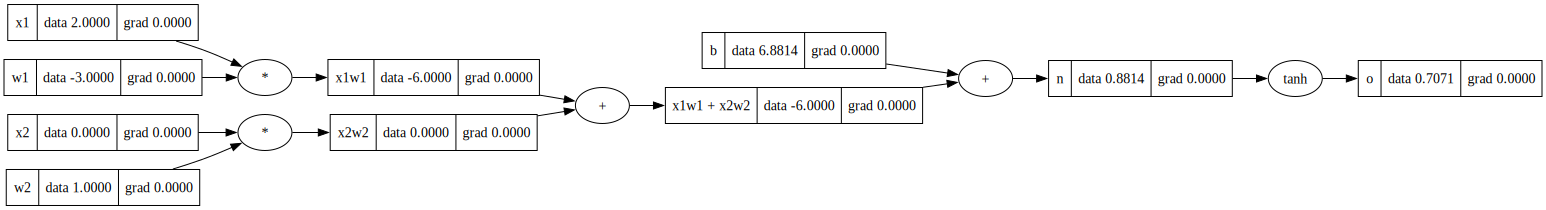

In [101]:
draw_dot(o)

In [68]:
# Manually determine gradients of neuron
o.grad = 1.0

# do/dn = 1-tanh(x)^2
n.grad = 0.5  # 1-o.data**2

# Bias addition (gradient stays the same - flows back)
x1w1x2w2.grad = 0.5
b.grad = 0.5

# Compontent addition (gradient stays the same - flows back)
x1w1.grad = 0.5
x2w2.grad = 0.5

# Weighted sum
x1.grad = -3.0 * 0.5
w1.grad = 2.0 * 0.5
x2.grad = 1.0 * 0.5
w2.grad = 0.0 * 0.5

In [84]:
# Semi-automatic backpropagation
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

In [92]:
# Fully automatic - see backpropagation method in Value
o.backward()

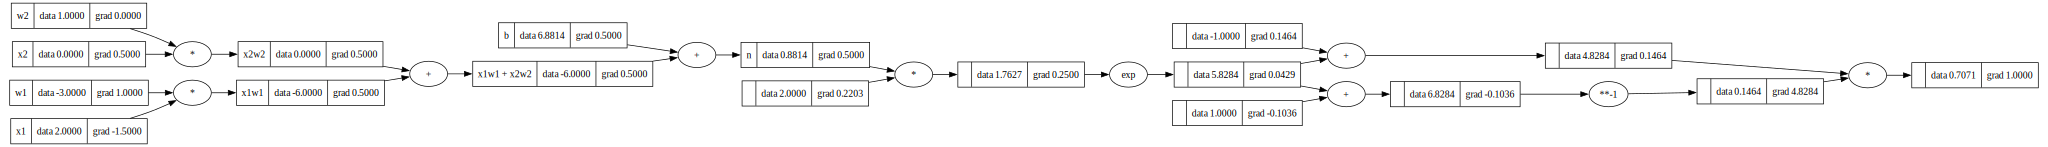

In [106]:
# Define tanh manually in single neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# ---
# o = n.tanh(); o.label = 'o'
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ---
o.backward()
draw_dot(o)

In [113]:
# Same neuron in pytorch
import torch

x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('w1', w1.grad.item())
print('x1', x1.grad.item())
print('w2', w2.grad.item())
print('x2', x2.grad.item())

0.7071066904050358
---
w1 1.0000002567688737
x1 -1.5000003851533106
w2 0.0
x2 0.5000001283844369


In [191]:
# Neuron and Layer class
import random

class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


Value(data=0.15054493684121822)

In [222]:
# Initialize NN

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.874812297873295)

In [223]:
len(n.parameters())

41

In [224]:
# Example data
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]


In [227]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)], Value(0))

    # Show MLP with loss
    # draw_dot(loss)

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update with learning rate
    for p in n.parameters():
        p.data += -0.05 * p.grad
        
    print(k, loss.data)

0 3.930388316485434e-06
1 3.929419911294594e-06
2 3.92845199908537e-06
3 3.927484579477203e-06
4 3.9265176520888365e-06
5 3.925551216542258e-06
6 3.924585272457432e-06
7 3.9236198194558105e-06
8 3.922654857159903e-06
9 3.921690385190185e-06
10 3.920726403169945e-06
11 3.919762910721324e-06
12 3.918799907468388e-06
13 3.917837393034502e-06
14 3.916875367043197e-06
15 3.915913829119049e-06
16 3.9149527788872494e-06
17 3.913992215970963e-06
18 3.91303213999835e-06
19 3.9120725505946704e-06


In [226]:
ypred

[Value(data=0.9999999999999913),
 Value(data=-0.9987439977521139),
 Value(data=-0.9999953789295604),
 Value(data=0.9999999999999717)]